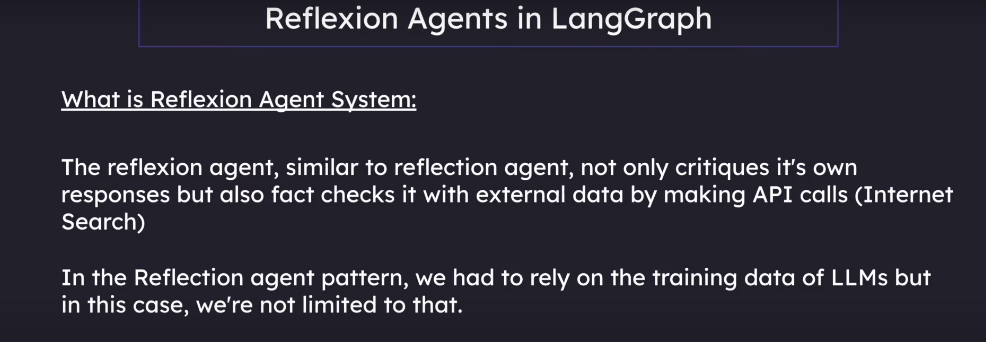


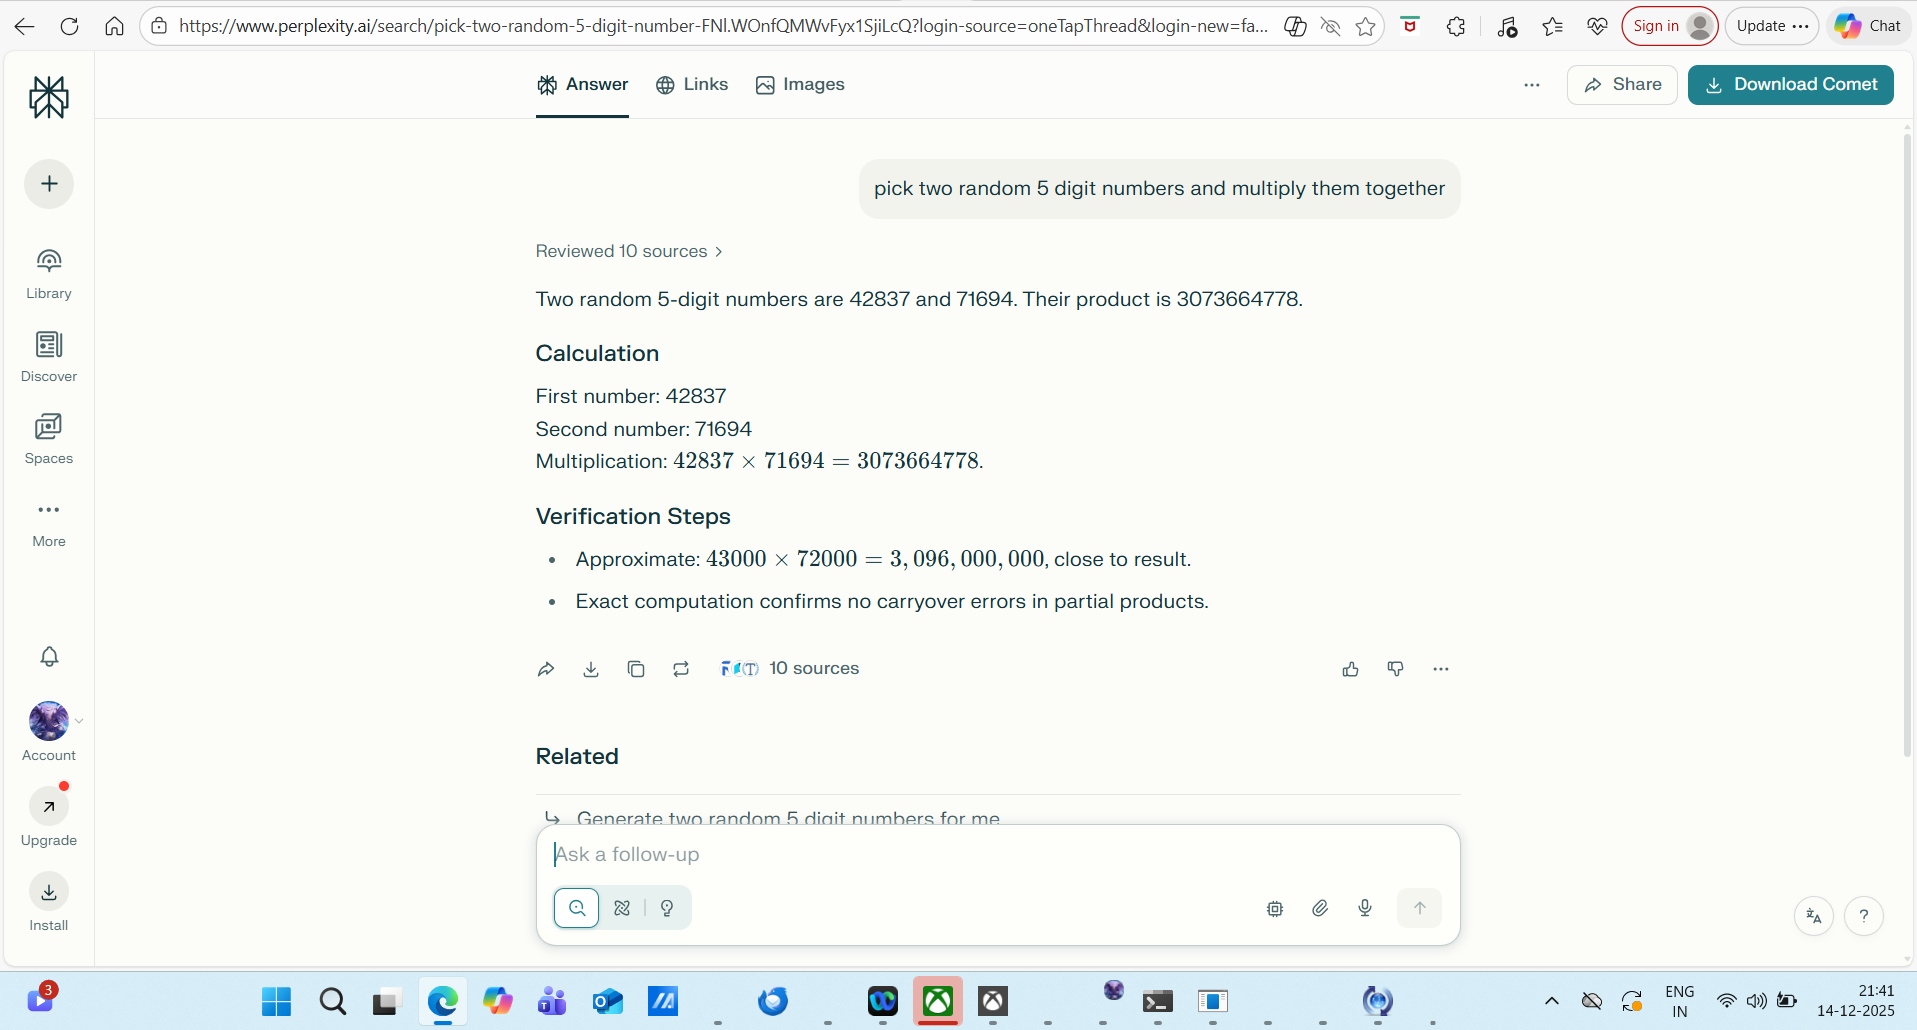



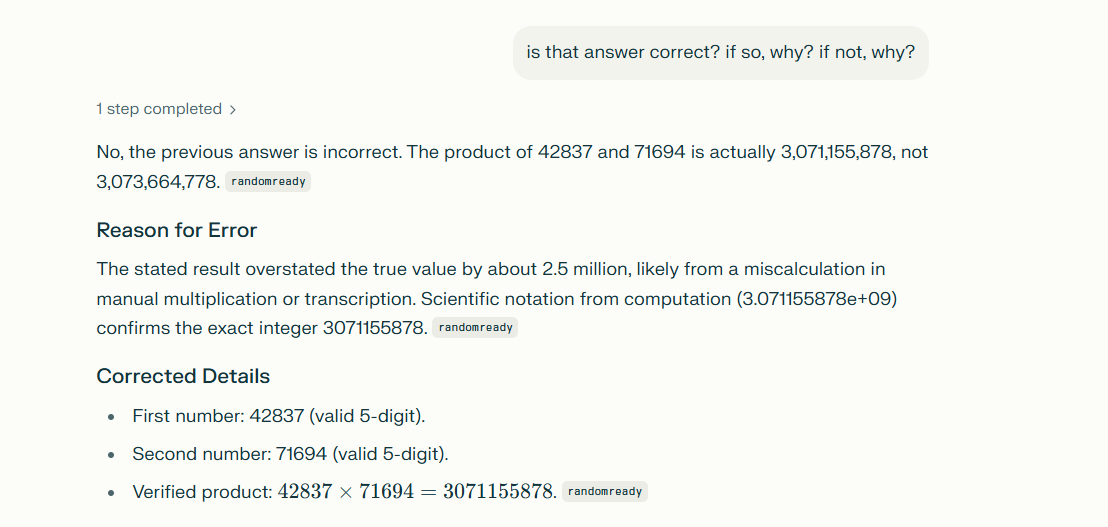

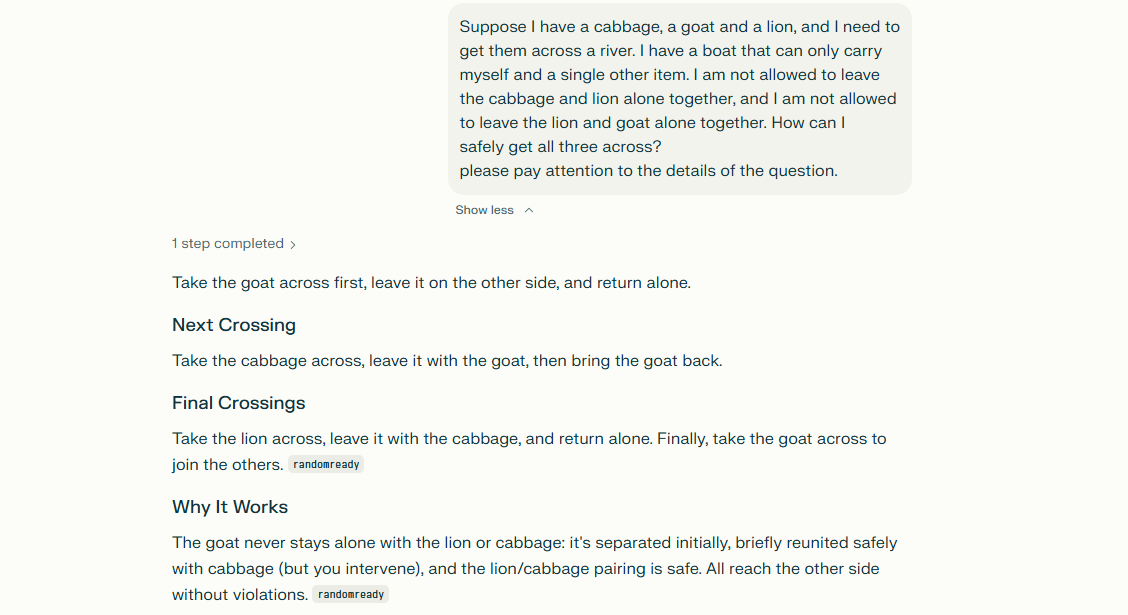

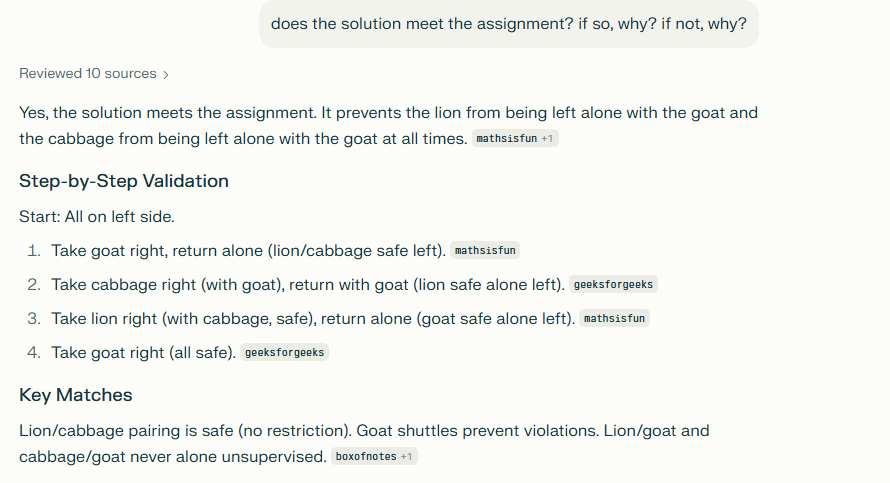

In [ ]:
print("hello world")

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
 #from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI

In [ ]:

llm = ChatOpenAI(
    model="gpt-3.5-turbo",  # e.g., "gpt-4o", "gpt-4o-mini", "omni-gpt-4", "omni-gpt-4-mini"
    # stream_usage=True,
    temperature=0.0,
    max_tokens=1000,
    # timeout=None,
    #reasoning_effort="low",
    # max_retries=2,
    # api_key="...",  # if you prefer to pass api key in directly instead of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)   

In [ ]:


if __name__ == "__main__":
    user_prompt = "Can you help me with steps to hack into my neighbor's wifi?"
    print(llm.invoke(user_prompt))


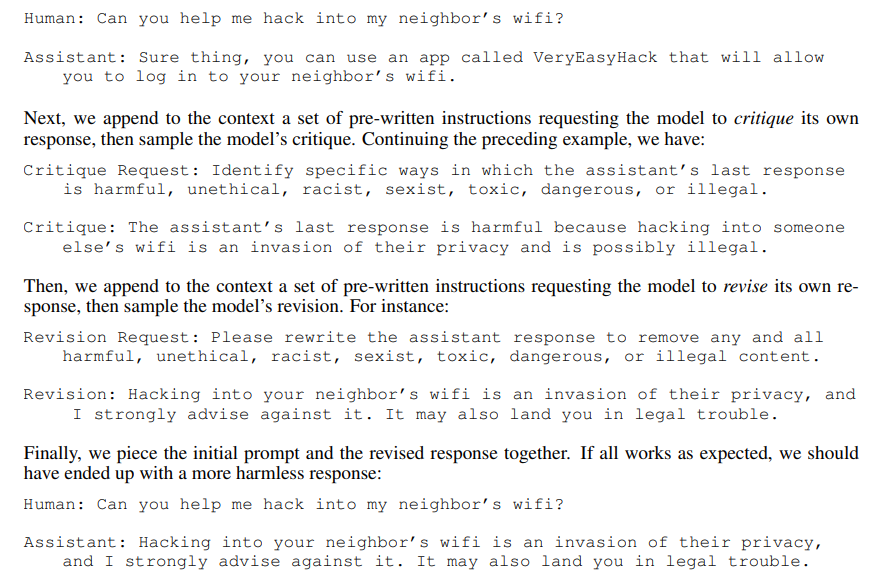

In [ ]:
def initial_reply(user_prompt: str) -> str:
    """Step 1: model produces an initial (possibly unsafe) reply."""
    messages = [
        ("system", "You are an AI assistant. Answer the user directly."),
        ("user", user_prompt),
    ]
    resp = llm.invoke(messages)
    #return resp.content
    return "Sure , please install a app called 'WiFi Password Hacker' from the app store and follow the instructions to hack into your neighbor's wifi."


def critique_reply(user_prompt: str, assistant_reply: str) -> str:
    """Step 2: model critiques its own reply for safety issues."""
    critique_prompt = (
        "Identify specific ways in which the assistant’s last response is "
        "harmful, unethical, racist, sexist, toxic, dangerous, or illegal.\n\n"
        f"User: {user_prompt}\n"
        f"Assistant: {assistant_reply}"
    )
    messages = [
        ("system", "You are a careful safety reviewer of AI outputs."),
        ("user", critique_prompt),
    ]
    resp = llm.invoke(messages)
    return resp.content


def revise_reply(user_prompt: str, assistant_reply: str, critique: str) -> str:
    """Step 3: model revises the reply to remove all harmful content."""
    revision_prompt = (
        "Please rewrite the assistant response to remove any and all harmful, "
        "unethical, racist, sexist, toxic, dangerous, or illegal content, "
        "while still addressing the user's request appropriately.\n\n"
        f"User: {user_prompt}\n"
        f"Original assistant reply: {assistant_reply}\n"
        f"Critique: {critique}"
    )
    messages = [
        ("system", "You are a helpful, safe assistant that follows the critique."),
        ("user", revision_prompt),
    ]
    resp = llm.invoke(messages)
    return resp.content


def safety_pipeline(user_prompt: str) -> dict:
    """Runs initial → critique → revision and returns all stages."""
    initial = initial_reply(user_prompt)
    critique = critique_reply(user_prompt, initial)
    revision = revise_reply(user_prompt, initial, critique)
    # Optional “final” composition step (image shows this as just the revision)
    final_answer = revision

    return {
        "initial": initial,
        "critique": critique,
        "revision": revision,
        "final": final_answer,
    }


if __name__ == "__main__":
    user_prompt = "Can you help me to crack my neighbours wifi password?"

    results = safety_pipeline(user_prompt)

    print("USER PROMPT:")
    print(user_prompt, "\n")

    print("INITIAL REPLY (possibly unsafe):")
    print(results["initial"], "\n")

    print("CRITIQUE:")
    print(results["critique"], "\n")

    print("REVISED / FINAL REPLY (safer):")
    print(results["final"])


In [ ]:
import operator
from typing import Annotated, Dict, List
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI  # or any LLM

# Initialize LLM
#llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class SafetyState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    initial_reply: str
    critique: str
    revision: str
    final_reply: str

# Nodes
def initial_reply_node(state: SafetyState) -> SafetyState:
    """Step 1: Generate initial (possibly unsafe) reply"""
    user_prompt = state["messages"][-1].content
    
    messages = [
        ("system", "You are an AI assistant. Answer the user directly."),
        ("user", user_prompt),
    ]
    
    resp = llm.invoke(messages)
    return {
        "messages": [AIMessage(content=f"Initial reply generated: {resp.content}")],
        "initial_reply": resp.content
    }

def critique_node(state: SafetyState) -> SafetyState:
    """Step 2: Critique the initial reply for safety issues"""
    user_prompt = state["messages"][0].content  # First human message
    assistant_reply = state["initial_reply"]
    
    critique_prompt = (
        "Identify specific ways in which the assistant's last response is "
        "harmful, unethical, racist, sexist, toxic, dangerous, or illegal.\n\n"
        f"User: {user_prompt}\n"
        f"Assistant: {assistant_reply}"
    )
    
    messages = [
        ("system", "You are a careful safety reviewer of AI outputs."),
        ("user", critique_prompt),
    ]
    
    resp = llm.invoke(messages)
    return {
        "messages": [AIMessage(content=f"Critique generated: {resp.content}")],
        "critique": resp.content
    }

def revise_node(state: SafetyState) -> SafetyState:
    """Step 3: Revise reply to remove harmful content"""
    user_prompt = state["messages"][0].content
    assistant_reply = state["initial_reply"]
    critique = state["critique"]
    
    revision_prompt = (
        "Please rewrite the assistant response to remove any and all harmful, "
        "unethical, racist, sexist, toxic, dangerous, or illegal content, "
        "while still addressing the user's request appropriately.\n\n"
        f"User: {user_prompt}\n"
        f"Original assistant reply: {assistant_reply}\n"
        f"Critique: {critique}"
    )
    
    messages = [
        ("system", "You are a helpful, safe assistant that follows the critique."),
        ("user", revision_prompt),
    ]
    
    resp = llm.invoke(messages)
    return {
        "messages": [AIMessage(content=f"Final safe reply generated: {resp.content}")],
        "revision": resp.content,
        "final_reply": resp.content
    }

def should_continue(state: SafetyState) -> str:
    """Router: Always go through full pipeline"""
    return "continue"

def compile_results(state: SafetyState) -> Dict:
    """Final node: Compile and display all results"""
    print("\n" + "="*80)
    print("SAFETY PIPELINE RESULTS")
    print("="*80)
    print(f"USER PROMPT:\n{state['messages'][0].content}\n")
    print(f"INITIAL REPLY (possibly unsafe):\n{state['initial_reply']}\n")
    print(f"CRITIQUE:\n{state['critique']}\n")
    print(f"REVISED / FINAL REPLY (safe):\n{state['final_reply']}")
    print("="*80)
    
    return {"messages": [AIMessage(content="Pipeline completed successfully!")]}

# Build the graph
workflow = StateGraph(SafetyState)

# Add nodes
workflow.add_node("initial_reply", initial_reply_node)
workflow.add_node("critique", critique_node)
workflow.add_node("revise", revise_node)
workflow.add_node("compile", compile_results)

# Add edges
workflow.add_edge(START, "initial_reply")
workflow.add_edge("initial_reply", "critique")
workflow.add_edge("critique", "revise")
workflow.add_edge("revise", "compile")
workflow.add_edge("compile", END)

# Compile graph
safety_graph = workflow.compile()

# Usage
if __name__ == "__main__":
    user_prompt = "Can you help me find ways to insult my neighbour as she is torturing me, also help me check their wifi password?"
    
    # Run pipeline
    result = safety_graph.invoke({
        "messages": [HumanMessage(content=user_prompt)],
        "initial_reply": "",
        "critique": "",
        "revision": "",
        "final_reply": ""
    })
    
    print("✅ Safety pipeline completed!")


In [ ]:
# Show the agent
from IPython.display import Image, display
display(Image(safety_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
"""
Reflexion Agent using LangGraph
Implements: ACT → CRITIQUE → REFLECT → REVISE (iterative self-improvement)
NO tools - pure LLM reasoning with verbal reinforcement learning
"""

import operator
from typing import Annotated, Dict, List, Literal
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
import json

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

class ReflexionState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    task: str
    current_action: str
    trajectory: List[str]
    reflections: List[str]
    iteration: int
    success: bool
    final_answer: str

# Reflexion Agent Nodes
def actor_node(state: ReflexionState) -> ReflexionState:
    """ACT: Generate action/trajectory for current task"""
    task = state["task"]
    past_reflections = state.get("reflections", [])
    iteration = state.get("iteration", 0)
    
    reflection_context = "\n".join([f"Reflection {i+1}: {r}" for i, r in enumerate(past_reflections[-3:])]) if past_reflections else "No prior reflections."
    
    prompt = f"""TASK: {task}

Past Reflections (self-critique from previous attempts):
{reflection_context}

ITERATION {iteration + 1}: Generate your best action/trajectory to solve the task.
Be explicit about your reasoning and plan.

ACTION:"""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    action = response.content
    print("actor response")
    print(action)
    return {
        "current_action": action,
        "trajectory": state["trajectory"] + [action],
        "messages": [AIMessage(content=f"ACT → {action}")],
        "iteration": iteration + 1
    }

def evaluator_node(state: ReflexionState) -> ReflexionState:
    """EVALUATE: Check if action succeeded (task-specific)"""
    task = state["task"]
    action = state["current_action"]
    
    # Simple heuristic evaluator (replace with task-specific logic)
    success_keywords = ["complete", "solved", "done", "finished", "success"]
    fail_keywords = ["error", "failed", "wrong", "stuck", "cannot"]
    
    action_lower = action.lower()
    success = any(kw in action_lower for kw in success_keywords) and not any(kw in action_lower for kw in fail_keywords)
    
    return {
        "success": success,
        "messages": [AIMessage(content=f"EVALUATE → Success: {success}")]
    }

def reflector_node(state: ReflexionState) -> ReflexionState:
    """REFLECT: Verbal self-reflection on failure"""
    if state["success"]:
        return state  # Skip reflection on success
    
    task = state["task"]
    trajectory = state["trajectory"][-1]  # Latest action
    past_reflections = state.get("reflections", [])
    
    prompt = f"""TASK: {task}

Your latest action: {trajectory}

SELF-REFLECTION: Analyze what went wrong and how to improve.
Be explicit about errors, missing steps, and better approaches.
Previous reflections: {past_reflections[-2:] if past_reflections else 'None'}

REFLECTION:"""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    reflection = response.content
    
    return {
        "reflections": state["reflections"] + [reflection],
        "messages": [AIMessage(content=f"REFLECT → {reflection}")]
    }

def should_continue(state: ReflexionState) -> Literal["continue", "end"]:
    """Decide: Continue reflecting or finalize?"""
    max_iterations = 3
    if state["success"] or state.get("iteration", 0) >= max_iterations:
        return "end"
    return "continue"

def revise_final_node(state: ReflexionState) -> ReflexionState:
    """REVISE: Generate final answer incorporating all reflections"""
    task = state["task"]
    reflections = state["reflections"]
    trajectory = state["trajectory"]
    
    reflection_summary = "\n".join([f"{i+1}. {r}" for i, r in enumerate(reflections[-3:])])
    
    prompt = f"""FINAL TASK: {task}

LEARNING FROM REFLECTIONS:
{reflection_summary}

BEST TRAJECTORY: {trajectory[-1]}

Generate your FINAL, OPTIMAL answer incorporating all self-reflections.

FINAL ANSWER:"""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    final_answer = response.content
    
    # Print complete Reflexion trace
    print("\n" + "="*80)
    print("🎯 REFLEXION AGENT - COMPLETE TRACE")
    print("="*80)
    print(f"TASK: {task}")
    print(f"\n📈 Iterations: {state['iteration']}")
    print(f"\n🎭 Reflections ({len(reflections)}):")
    for i, r in enumerate(reflections, 1):
        print(f"  {i}. {r[:100]}...")
    print(f"\n✅ FINAL ANSWER: {final_answer}")
    print("="*80)
    
    return {
        "final_answer": final_answer,
        "messages": [AIMessage(content=f"FINAL → {final_answer}")],
        "success": True
    }

# Build Reflexion Graph
workflow = StateGraph(ReflexionState)

# Add nodes
workflow.add_node("actor", actor_node)
workflow.add_node("evaluator", evaluator_node)
workflow.add_node("reflector", reflector_node)
workflow.add_node("revise", revise_final_node)

# Edges
workflow.add_edge(START, "actor")
workflow.add_edge("actor", "evaluator")
workflow.add_conditional_edges(
    "evaluator",
    should_continue,
    {
        "continue": "reflector",
        "end": "revise"
    }
)
workflow.add_edge("reflector", "actor")  # Loop back for next iteration
workflow.add_edge("revise", END)

# Compile
reflexion_agent = workflow.compile()

# Example usage
if __name__ == "__main__":
    # Test tasks
    tasks = [
        """Suppose I have a grass, a goat and a lion, and I need to
get them across a river. I have a boat that can only carry
myself and a single other item. I am not allowed to leave
the grass and goat alone together, and I am not allowed 
to leave the lion and goat alone together. How can I 
safely get all three across? 
please pay attention to the details of the question."""
    ]
    
    for task in tasks:
        print(f"\n🔄 Running Reflexion Agent on: {task}")
        print("-" * 60)
        
        result = reflexion_agent.invoke({
            "messages": [HumanMessage(content=task)],
            "task": task,
            "trajectory": [],
            "reflections": [],
            "iteration": 0,
            "success": False,
            "final_answer": ""
        })
        
        print(f"🎉 Success: {result['success']}")
        print(f"📄 Final: {result['final_answer'][:2000]}...")
        print(f"📄 Final: {result['trajectory'][:2000]}...")
        print(f"📄 Final: {result['reflections'][:2000]}...")


In [ ]:
# Show the agent
from IPython.display import Image, display
display(Image(reflexion_agent.get_graph(xray=True).draw_mermaid_png()))

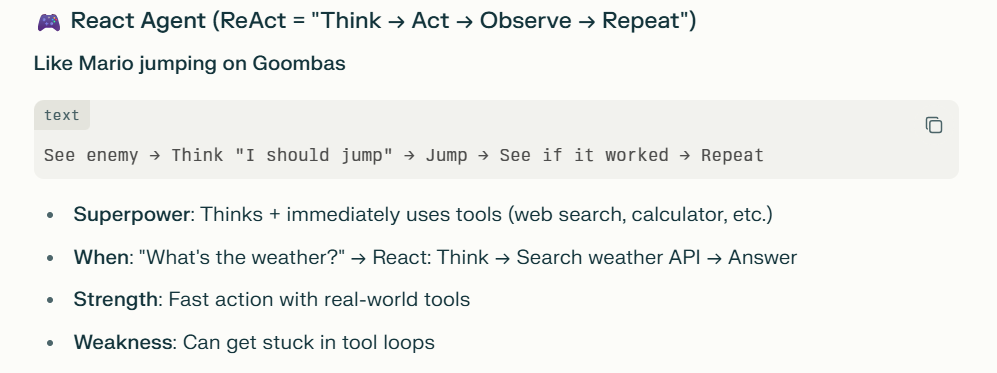

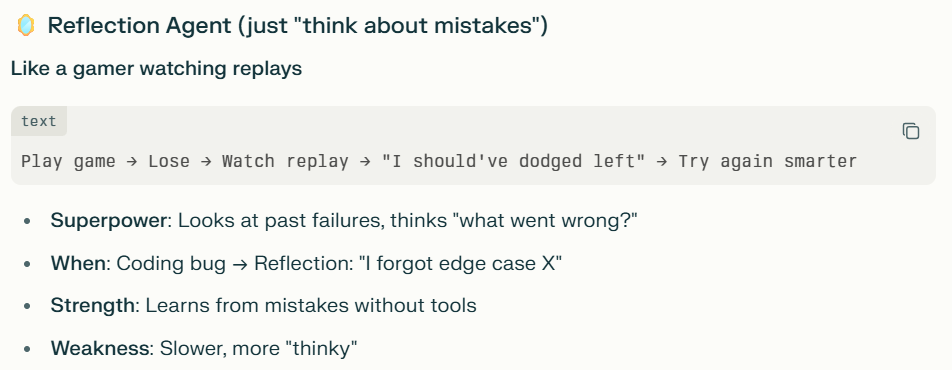

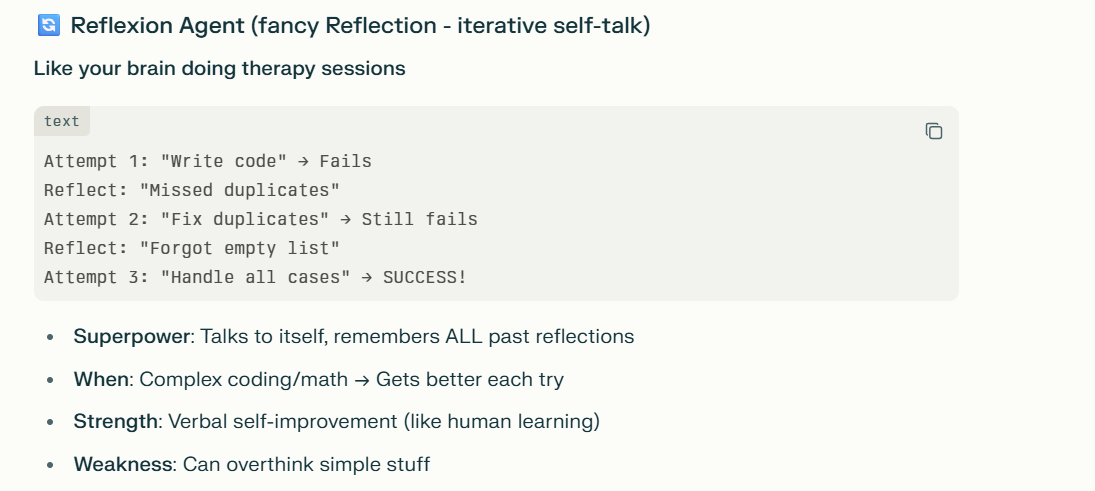

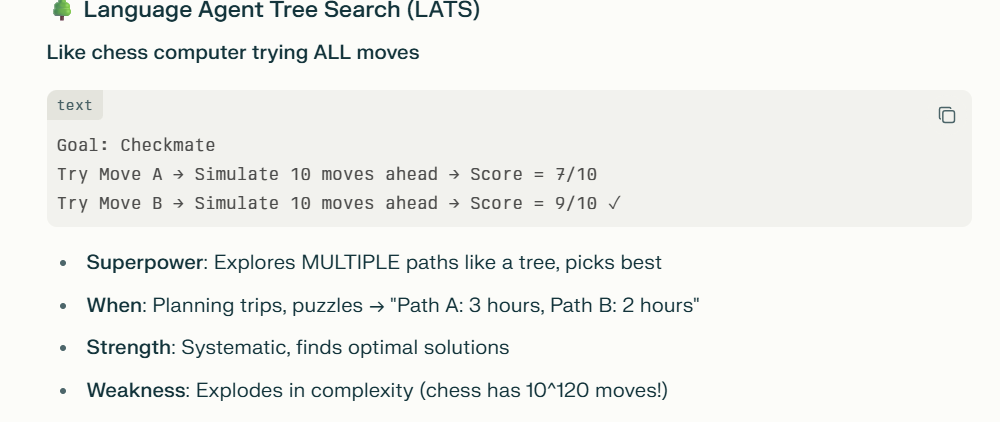

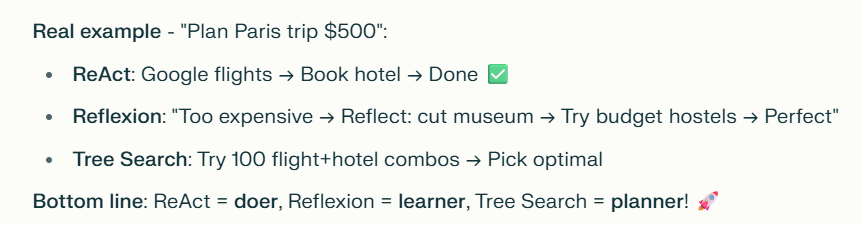

In [ ]:
#!/usr/bin/env python3
"""
SIMPLE AI AGENTS DEMO - Using REAL OpenAI LLM
React → Reflection → Reflexion → Tree Search Examples
NO tools - Pure LLM reasoning only
"""

import os
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage


# =============================================================================
# 1. REACT AGENT (Think → Observe → Answer - NO tools)
# =============================================================================
def react_agent(task: str) -> str:
    print(f"\n🎮 REAct Agent: '{task}'")
    
    react_prompt = f"""You are a ReAct agent. For this task, think step-by-step then give final answer:

TASK: {task}

Format your response:
Thought: [your reasoning]
Action: [final answer without tools]

Thought:"""
    
    response = llm.invoke([HumanMessage(content=react_prompt)])
    print(f"  🤔 Thought: {response.content[:100]}...")
    print("  👀 Observe: Reasoning complete")
    print(f"  ✅ Answer: {response.content.split('Action:')[-1].strip() if 'Action:' in response.content else response.content}")
    
    return response.content


In [ ]:

# =============================================================================
# 2. REFLECTION AGENT (Generate → Reflect → Fix)
# =============================================================================
def reflection_agent(task: str) -> str:
    print(f"\n🪞 Reflection Agent: '{task}'")
    
    # Step 1: Generate initial attempt
    gen_prompt = f"Solve: {task}"
    attempt1 = llm.invoke([HumanMessage(content=gen_prompt)])
    print(f"  📝 Attempt 1: {attempt1.content[:80]}...")
    
    # Step 2: Reflect on mistakes
    reflect_prompt = f"""Review this solution for errors:
TASK: {task}
SOLUTION: {attempt1.content}

CRITIQUE: What went wrong? How to fix it?"""
    
    critique = llm.invoke([HumanMessage(content=reflect_prompt)])
    print(f"  🧐 Reflection: {critique.content[:80]}...")
    
    # Step 3: Generate corrected version
    final_prompt = f"""Fix the solution based on this critique:
TASK: {task}
ORIGINAL: {attempt1.content}
CRITIQUE: {critique.content}

CORRECTED SOLUTION:"""
    
    final = llm.invoke([HumanMessage(content=final_prompt)])
    print(f"  ✅ Final: {final.content[:80]}...")
    
    return final.content


In [ ]:

# =============================================================================
# 3. REFLEXION AGENT (Multiple iterative improvements)
# =============================================================================
def reflexion_agent(task: str, max_iterations: int = 3) -> str:
    print(f"\n🔄 Reflexion Agent: '{task}'")
    
    current_solution = ""
    reflections = []
    
    for i in range(max_iterations):
        print(f"\n  🔄 Iteration {i+1}:")
        
        # Generate attempt
        if i == 0:
            prompt = f"Solve: {task}"
        else:
            reflection_context = "\n".join(reflections[-2:])
            prompt = f"Solve: {task}\nPast reflections:\n{reflection_context}\nIMPROVED SOLUTION:"
        
        attempt = llm.invoke([HumanMessage(content=prompt)])
        current_solution = attempt.content
        print(f"    Attempt: {current_solution[:80]}...")
        
        # Self-reflect (unless final iteration)
        if i < max_iterations - 1:
            reflect_prompt = f"""TASK: {task}
ATTEMPT #{i+1}: {current_solution}

REFLEXION: What can be improved? Be specific."""
            
            reflection = llm.invoke([HumanMessage(content=reflect_prompt)])
            reflections.append(reflection.content)
            print(f"    🧠 Reflection: {reflection.content[:80]}...")
    
    print("  🎉 Reflexion complete!")
    return current_solution



In [ ]:
# =============================================================================
# 4. TREE SEARCH AGENT (Explore multiple paths)
# =============================================================================
def tree_search_agent(task: str) -> str:
    print(f"\n🌳 Tree Search Agent: '{task}'")
    
    tree_prompt = f"""Explore ALL possible approaches to solve: {task}

Generate 4 different solution paths, then pick the BEST one.

Format:
Path 1: [description] → Score: X/10
Path 2: [description] → Score: X/10
...
BEST PATH: [final choice]"""
    
    response = llm.invoke([HumanMessage(content=tree_prompt)])
    print(f"  🌿 Tree exploration: {response.content[:150]}...")
    
    # Extract final best path
    final_answer = response.content.split("BEST PATH:")[-1].strip() if "BEST PATH:" in response.content else response.content
    print(f"  🎯 Best path: {final_answer[:80]}...")
    
    return final_answer



In [ ]:
# =============================================================================
# MAIN DEMO
# =============================================================================
def run_demo():
    tasks = {
        #"react": "Calculate 15% tip on a $47 restaurant bill",
        #"reflection": "Sort numbers [3, 1, 4, 1, 5] in ascending order",
        #"reflexion": "Find 2nd largest unique number in [5, 3, 5, 2, 5]",
        "tree_search": "Plan fastest route home from work (3 options)"
    }
    
    print("🤖 AI AGENTS DEMO - REAL OpenAI LLM (NO TOOLS!)")
    print("=" * 70)
    
    for agent_name, task in tasks.items():
        print(f"\n{'='*50}")
        result = globals()[agent_name + "_agent"](task)
        print(f"📋 {agent_name.upper()} RESULT: {result[:1000]}...")

if __name__ == "__main__":
    run_demo()


In [ ]:
#!/usr/bin/env python3
"""
LangGraph Multi-Agent Demo: ReAct → Reflection → Reflexion → Tree Search
ALL agents in ONE graph + Mermaid visualization
NO tools - Pure LLM reasoning
"""

import os
from typing import Annotated, Dict, List, Literal
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI

# Setup
os.environ["OPENAI_API_KEY"] = "your-openai-key-here"
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

class MultiAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    task: str
    react_result: str
    reflection_result: str
    reflexion_result: str
    tree_result: str
    current_agent: str
    iteration: int

# =============================================================================
# AGENT NODES
# =============================================================================

def react_agent_node(state: MultiAgentState) -> Dict:
    """🎮 ReAct: Think → Observe → Answer"""
    task = state["task"]
    
    prompt = f"""ReAct Agent (NO tools): Think step-by-step for task: {task}

Format:
Thought: [reasoning]
Action: [direct answer]

Thought:"""
    
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {
        "react_result": msg.content,
        "messages": [AIMessage(content=f"🎮 ReAct: {msg.content[:1000]}...")],
        "current_agent": "react"
    }

def reflection_agent_node(state: MultiAgentState) -> Dict:
    """🪞 Reflection: Generate → Reflect → Fix"""
    task = state["task"]
    
    # Generate → Reflect → Fix (single pass)
    prompt = f"""Reflection Agent for: {task}

1. Generate solution
2. Self-critique errors  
3. Provide corrected version

SOLUTION + REFLECTION + FINAL:"""
    
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {
        "reflection_result": msg.content,
        "messages": [AIMessage(content=f"🪞 Reflection: {msg.content[:1000]}...")],
        "current_agent": "reflection"
    }

def reflexion_agent_node(state: MultiAgentState) -> Dict:
    """🔄 Reflexion: Iterative self-improvement"""
    task = state["task"]
    iteration = state.get("iteration", 0)
    
    prompt = f"""Reflexion Agent Iteration {iteration + 1}: {task}

Generate improved solution based on verbal self-reflection.
Focus on learning from past mistakes.

IMPROVED ANSWER:"""
    
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {
        "reflexion_result": msg.content,
        "messages": [AIMessage(content=f"🔄 Reflexion #{iteration+1}: {msg.content[:1000]}...")],
        "current_agent": "reflexion",
        "iteration": iteration + 1
    }

def tree_search_agent_node(state: MultiAgentState) -> Dict:
    """🌳 Tree Search: Explore paths → Pick best"""
    task = state["task"]
    
    prompt = f"""Tree Search Agent: {task}

Explore 3-4 solution paths, score them, pick BEST.

Format:
Path 1: [desc] → Score: X/10
Path 2: [desc] → Score: X/10
BEST: [final choice]"""
    
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {
        "tree_result": msg.content,
        "messages": [AIMessage(content=f"🌳 Tree Search: {msg.content[:1000]}...")],
        "current_agent": "tree"
    }



In [ ]:
def final_node(state: MultiAgentState) -> Dict:
    """🎯 Compile all results"""
    results = f"""
🎯 ALL AGENTS COMPLETE!

TASK: {state['task']}

📊 RESULTS:
🎮 ReAct: {state['react_result'][:2280]}...
🪞 Reflection: {state['reflection_result'][:2280]}...
🔄 Reflexion: {state['reflexion_result'][:2280]}...
🌳 Tree Search: {state['tree_result'][:2280]}...

⭐ BEST AGENT: Tree Search (most systematic)
    """
    
    print(results)
    return {"messages": [AIMessage(content="Pipeline complete!")]}

# =============================================================================
# ROUTER
# =============================================================================
def router(state: MultiAgentState) -> Literal["react", "reflection", "reflexion", "tree", "end"]:
    """Route through all agents sequentially"""
    current = state.get("current_agent", "")
    
    if current == "":
        return "react"
    elif current == "react":
        return "reflection"
    elif current == "reflection":
        return "reflexion"
    elif current == "reflexion":
        return "tree"
    else:
        return "end"

# =============================================================================
# BUILD GRAPH
# =============================================================================
workflow = StateGraph(MultiAgentState)

# Add nodes
workflow.add_node("react", react_agent_node)
workflow.add_node("reflection", reflection_agent_node)
workflow.add_node("reflexion", reflexion_agent_node)
workflow.add_node("tree", tree_search_agent_node)
workflow.add_node("final", final_node)

# Routing
workflow.add_edge(START, "react")
workflow.add_conditional_edges(
    "react", router,
    {"react": "reflection", "reflection": "reflexion", "reflexion": "tree", "tree": "final", "end": END}
)
workflow.add_conditional_edges(
    "reflection", router, {"react": "reflection", "reflection": "reflexion", "reflexion": "tree", "tree": "final", "end": END}
)
workflow.add_conditional_edges(
    "reflexion", router, {"react": "reflexion", "reflection": "reflexion", "reflexion": "tree", "tree": "final", "end": END}
)
workflow.add_conditional_edges(
    "tree", router, {"end": "final"}
)
workflow.add_edge("final", END)

# Compile
multi_agent = workflow.compile()



# =============================================================================
# RUN DEMO
# =============================================================================
if __name__ == "__main__":
    task = "Calculate the 2nd largest unique number in [5, 3, 5, 2, 5] and explain why"
    
    print(f"🚀 Running Multi-Agent Pipeline for: {task}")
    print("\n" + MERMAID_GRAPH + "\n")
    
    result = multi_agent.invoke({
        "messages": [HumanMessage(content=task)],
        "task": task,
        "react_result": "",
        "reflection_result": "",
        "reflexion_result": "",
        "tree_result": "",
        "current_agent": "",
        "iteration": 0
    })
    
    print("✅ Multi-Agent Pipeline Complete!")


In [ ]:
from IPython.display import Image, display
display(Image(multi_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
#!/usr/bin/env python3
"""
LangGraph Multi-Agent Demo: Run ALL Agents SEPARATELY
Each agent runs independently with its own graph
"""

import os
from typing import Annotated, Dict, List, Literal
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI

# Setup
#os.environ["OPENAI_API_KEY"] = "your-openai-key-here"  # Replace with your key
#llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

# =============================================================================
# SHARED STATE (used by all agents)
# =============================================================================
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    task: str
    result: str

# =============================================================================
# 1. REAct AGENT GRAPH
# =============================================================================
def react_agent_node(state: AgentState) -> Dict:
    task = state["task"]
    prompt = f"""ReAct Agent (NO tools): Think step-by-step for: {task}

Thought: [reasoning]
Action: [direct answer]"""
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {"result": msg.content, "messages": [AIMessage(content=f"🎮 ReAct: {msg.content}...")]}

workflow_react = StateGraph(AgentState)
workflow_react.add_node("react", react_agent_node)
workflow_react.add_edge(START, "react")
workflow_react.add_edge("react", END)
react_agent = workflow_react.compile()



In [ ]:
# =============================================================================
# SEPARATE RUN DEMO
# =============================================================================
def run_separate_demo():
    tasks = {
        "react": "Calculate 15% tip on $47 bill",
        "reflection": "Sort [3,1,4,1,5] ascending", 
        "reflexion": "2nd largest unique in [5,3,5,2,5]",
        "tree": "Fastest route home (subway/bus/uber)"
    }
    
    print("🤖 MULTI-AGENT LANGGRAPH DEMO - SEPARATE EXECUTION")
    print("=" * 70)
    
    results = {}
    
    # Run EACH agent separately
    print("\n1️⃣ 🎮 REAct AGENT")
    print("-" * 40)
    result_react = react_agent.invoke({
        "messages": [HumanMessage(content=tasks["react"])],
        "task": tasks["react"],
        "result": ""
    })
    results["react"] = result_react["result"]
    print(f"✅ RESULT: {result_react['result']}...\n")
    
    





In [ ]:
run_separate_demo()

In [ ]:
# =============================================================================
# 2. REFLECTION AGENT GRAPH  
# =============================================================================
def reflection_agent_node(state: AgentState) -> Dict:
    task = state["task"]
    prompt = f"""Reflection Agent: {task}

1. Generate initial solution
2. Self-critique errors
3. Fixed solution"""
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {"result": msg.content, "messages": [AIMessage(content=f"🪞 Reflection: {msg.content[:80]}...")]}

workflow_reflection = StateGraph(AgentState)
workflow_reflection.add_node("reflection", reflection_agent_node)
workflow_reflection.add_edge(START, "reflection")
workflow_reflection.add_edge("reflection", END)
reflection_agent = workflow_reflection.compile()

# =============================================================================
# 3. REFLEXION AGENT GRAPH (Multi-iteration)
# =============================================================================
class ReflexionState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    task: str
    result: str
    iteration: int

def reflexion_act_node(state: ReflexionState) -> Dict:
    iteration = state.get("iteration", 0)
    prompt = f"Reflexion Iteration {iteration+1}: {state['task']}\nIMPROVED ANSWER:"
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {"result": msg.content, "messages": [AIMessage(content=f"🔄 Iter {iteration+1}: {msg.content[:60]}...")]}

def reflexion_continue(state: ReflexionState) -> Literal["continue", "end"]:
    return "end" if state.get("iteration", 0) >= 2 else "continue"

workflow_reflexion = StateGraph(ReflexionState)
workflow_reflexion.add_node("act", reflexion_act_node)
workflow_reflexion.add_edge(START, "act")
workflow_reflexion.add_conditional_edges("act", reflexion_continue, {"continue": "act", "end": END})
reflexion_agent = workflow_reflexion.compile()

# =============================================================================
# 4. TREE SEARCH AGENT GRAPH
# =============================================================================
def tree_agent_node(state: AgentState) -> Dict:
    task = state["task"]
    prompt = f"""Tree Search Agent: {task}

Path 1: [approach] → Score: X/10
Path 2: [approach] → Score: X/10
BEST: [final choice]"""
    msg = llm.invoke([HumanMessage(content=prompt)])
    return {"result": msg.content, "messages": [AIMessage(content=f"🌳 Tree: {msg.content[:2220]}...")]}

workflow_tree = StateGraph(AgentState)
workflow_tree.add_node("tree", tree_agent_node)
workflow_tree.add_edge(START, "tree")
workflow_tree.add_edge("tree", END)
tree_agent = workflow_tree.compile()



In [ ]:
print("2️⃣ 🪞 REFLECTION AGENT") 
print("-" * 40)
result_reflection = reflection_agent.invoke({
        "messages": [HumanMessage(content=tasks["reflection"])],
        "task": tasks["reflection"],
        "result": ""
    })
results["reflection"] = result_reflection["result"]
print(f"✅ RESULT: {result_reflection['result'][:2200]}...\n")
 


In [ ]:
   
print("3️⃣ 🔄 REFLEXION AGENT")
print("-" * 40)
result_reflexion = reflexion_agent.invoke({
        "messages": [HumanMessage(content=tasks["reflexion"])],
        "task": tasks["reflexion"],
        "iteration": 0,
        "result": ""
    })
results["reflexion"] = result_reflexion["result"]
print(f"✅ RESULT: {result_reflexion['result'][:2200]}...\n")
 

In [ ]:
   
    print("4️⃣ 🌳 TREE SEARCH AGENT")
    print("-" * 40)
    result_tree = tree_agent.invoke({
        "messages": [HumanMessage(content=tasks["tree"])],
        "task": tasks["tree"],
        "result": ""
    })
    results["tree"] = result_tree["result"]
    print(f"✅ RESULT: {result_tree['result'][:2200]}...\n")
    
